# Imports

In [1]:
from pathlib import Path
import json
import collections

import pandas as pd
import matplotlib.pyplot as plt


# Paths

Raw and processed data will be stored in the data directory. Paths to various forms of the data are listed below

In [2]:
RAW_PATH = Path("../data/raw/conference_data.json")  # adjust ../ if needed

# Initial Inspections

The scraper extracted a number of metadata, but further refining is required. For this project we require information about the papers being reviewed, and any decisions amde about them. This initial work is made to ensure each entry contains the necessary information.

In [3]:
with RAW_PATH.open("r", encoding="utf-8") as f:
    records = json.load(f)

len(records), records[0]

(7404,
 {'venue': 'ICLR.cc',
  'year': '2024',
  'paper_id': 'cXs5md5wAq',
  'title': 'Modelling Microbial Communities with Graph Neural Networks',
  'abstract': 'Understanding the interactions and interplay of microorganisms is a great challenge with many applications in medical and environmental settings. In this work, we model bacterial communities directly from their genomes using graph neural networks (GNNs). GNNs leverage the inductive bias induced by the set nature of bacteria, enforcing permutation invariance and granting combinatorial generalization. We propose to learn the dynamics implicitly by directly predicting community relative abundance profiles at steady state, thus escaping the need for growth curves. On two real-world datasets, we show for the first time generalization to unseen bacteria and different community structures. \nTo investigate the prediction results more deeply, we created a simulation for flexible data generation and analyze effects of bacteria interac

In [4]:
num_with_decision = sum(1 for r in records if r.get("decision"))
num_with_title = sum(1 for r in records if r.get("title"))
num_with_abstract = sum(1 for r in records if r.get("abstract"))

num_with_decision, num_with_title, num_with_abstract

(5780, 7404, 7404)

As we can see above, over a thousand entries lack decisions. It may be worth examining what these entries look like to understand why they might be missing

In [8]:
missing_decision = [r for r in records if not r.get("decision")]
len(missing_decision)

1624

In [18]:
missing_decision[3]

{'venue': 'ICLR.cc',
 'year': '2024',
 'paper_id': '6AtXCnHCFy',
 'title': 'FSN: Feature Shift Network for Load-Domain Domain Generalization',
 'abstract': 'Conventional deep learning methods for fault detection often assume that the training and the testing sets share the same fault pattern spaces and domain spaces. However, some fault patterns are rare, and many real-world faults have not appeared in the training set. As a result, it’s hard for the trained model to achieve desirable performance on the testing set. \nIn this paper, we introduce a novel domain generalization, Load-Domain (LD) domain generalization, which is based on the analysis of the CWRU bearing dataset and its domain division method. For this scenario, we propose a feature shift model called FSN (Feature Shift Network). In the bearing dataset, domains are divided based on different operating conditions which have specific loads, so it’s equivalent to load-based domain division. Moreover, the domain label correspond

## My Verdict

It looks like the majority of papers with a null value for decision were unanimously rejected. Thus I think it's fair to also assign these entries as rejected.

In [19]:
decision_counts = collections.Counter(
    (r.get("decision") or "MISSING") for r in records
)
decision_counts

Counter({'Reject': 3519,
         'Accept (poster)': 1808,
         'MISSING': 1624,
         'Accept (spotlight)': 367,
         'Accept (oral)': 86})

Below we will assign each entry a value of 0 or 1 depending on its decision. As decided above, entries missing a decision value will be assigned 0 (rejected). This will be the clean dataset moving forward.

In [29]:
def decision_to_label(decision):
    """
    Map decisions to labels:
    - Accept => 1
    - Everything else (None, missing, rejects) => 0
    """
    if not decision:
        return 0
    d = str(decision).lower()
    if "accept" in d:
        return 1
    return 0


clean_examples = []

for r in records:
    title = (r.get("title") or "").strip()
    abstract = (r.get("abstract") or "").strip()

    # Skip incomplete metadata
    if not title or not abstract:
        continue

    decision = r.get("decision")
    label = decision_to_label(decision)

    venue = r.get("venue")
    year = r.get("year")
    paper_id = r.get("paper_id")

    # Extract reviews
    raw_reviews = r.get("reviews", []) or []

    processed_reviews = []
    for rev in raw_reviews:
        processed_reviews.append({
            "summary": rev.get("summary"),
            "strengths": rev.get("strengths"),
            "weaknesses": rev.get("weaknesses"),
            "questions": rev.get("questions"),
            "rating": rev.get("rating"),
            "confidence": rev.get("confidence"),
        })

    clean_examples.append({
        "venue": venue,
        "year": year,
        "paper_id": paper_id,
        "title": title,
        "abstract": abstract,
        "decision": decision,  # may be None
        "label": label,        # 1 = accept, 0 = reject
        "reviews": processed_reviews,
    })

len(clean_examples)

7404

## Initial inspection of cleaned data

In [30]:
df = pd.DataFrame(clean_examples)
df.head()


,venue,year,paper_id,title,abstract,decision,label,reviews
0,ICLR.cc,2024,cXs5md5wAq,Modelling Microbial Communities with Graph Neu...,Understanding the interactions and interplay o...,Reject,0,[{'summary': 'The paper aims at predicting ste...
1,ICLR.cc,2024,rhgIgTSSxW,TabR: Tabular Deep Learning Meets Nearest Neig...,Deep learning (DL) models for tabular data pro...,Accept (poster),1,[{'summary': 'This paper considers the problem...
2,ICLR.cc,2024,kKRbAY4CXv,Neural Evolutionary Kernel Method: A Knowledge...,Numerical solution of partial differential equ...,Reject,0,[{'summary': 'The paper introduces a novel app...
3,ICLR.cc,2024,ApjY32f3Xr,PINNacle: A Comprehensive Benchmark of Physics...,While significant progress has been made on Ph...,Reject,0,[{'summary': 'This paper provides both a colle...
4,ICLR.cc,2024,eUgS9Ig8JG,SaNN: Simple Yet Powerful Simplicial-aware Neu...,Simplicial neural networks (SNNs) are deep mod...,Accept (spotlight),1,[{'summary': 'The paper describes an efficient...


We can calculate the distribution of decisions below

In [31]:
df["label"].value_counts(normalize=True)

label
0    0.694625
1    0.305375
Name: proportion, dtype: float64

In [32]:
df["abstract_len"] = df["abstract"].str.len()
df["abstract_len"].describe()

count    7404.000000
mean     1332.021745
std       307.192540
min         3.000000
25%      1123.000000
50%      1315.000000
75%      1520.250000
max      3523.000000
Name: abstract_len, dtype: float64

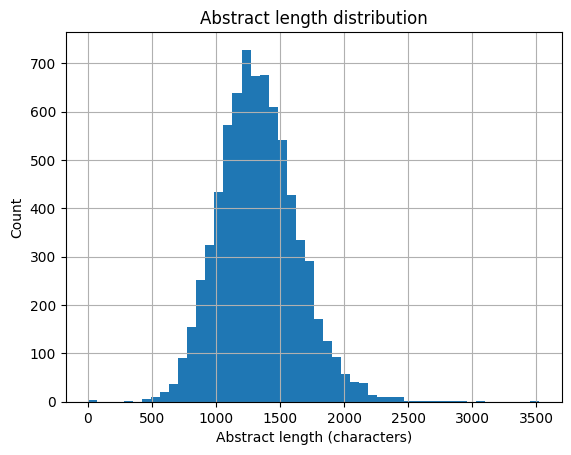

In [33]:
df["abstract_len"].hist(bins=50)
plt.xlabel("Abstract length (characters)")
plt.ylabel("Count")
plt.title("Abstract length distribution");

We have a few entries with abstracts that barely exist. It might be worth dropping those. But I think we can keep them.

## Deduplicate (if any exist)

In [34]:
df.duplicated(subset=["title", "abstract"]).sum()

0

# Export cleaned data

In [36]:
CLEAN_PATH = Path("../data/processed/iclr2024.json")

In [37]:
CLEAN_PATH.parent.mkdir(parents=True, exist_ok=True)

with CLEAN_PATH.open("w", encoding="utf-8") as f:
    for _, row in df.iterrows():
        obj = {
            "venue": row["venue"],
            "year": row["year"],
            "paper_id": row["paper_id"],
            "title": row["title"],
            "abstract": row["abstract"],
            "decision": row["decision"],
            "label": int(row["label"]),
            "reviews": row["reviews"],
        }
        f.write(json.dumps(obj, ensure_ascii=False) + "\n")

CLEAN_PATH, len(df)

(PosixPath('../data/processed/iclr2024.json'), 7404)

## Note

The above returns a JSONL file since the dataset is fairly large